# Import thư viện

In [30]:
import pandas as pd
import re
import numpy as np
import time
import os, json
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from underthesea import word_tokenize

import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import MT5Tokenizer, MT5ForConditionalGeneration, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, get_scheduler, get_linear_schedule_with_warmup


In [2]:
# Kiểm tra chương trình đang sử dụng thiết bị nào (CPU hay GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda)
print("Using device:", device)

12.9
Using device: cuda


# 1. Xử lí dữ liệu
## 1.1 Kiểm tra chính tả
Tách từ kết hợp tra cứu từ điển để tìm các từ bị dính liền hoặc sai chỉnh tả

In [ ]:
df = pd.read_excel('cleaned_data.xlsx')

def split_punctuations(tokens):
    result = []
    for tok in tokens:
        parts = re.findall(r'[!?.,;:]|\w+|[^\s\w]', tok, flags=re.UNICODE)
        result.extend(parts)
    return result

raw_word_list = word_tokenize(' '.join(df['question_note'].tolist()))
word_list = split_punctuations(raw_word_list)
word_freq = pd.Series(word_list).value_counts()
print(word_freq)

trú     1700
,       1578
.       1539
tạm     1292
tôi     1259
        ... 
DN         1
cổng       1
mở         1
quỳ        1
m          1
Name: count, Length: 1541, dtype: int64


In [ ]:

def load_dictionary(folder_path):
    records = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as f:
                for line in f:
                    try:
                        obj = json.loads(line.strip())
                        if "text" in obj and "source" in obj:
                            records.append({"word": obj["text"].lower(), "source": obj["source"]})
                    except:
                        continue
    return pd.DataFrame(records).drop_duplicates(subset="word").reset_index(drop=True)

def check(word, df_dict):
    return word.lower() in set(df_dict["word"])

df_dict = load_dictionary("dictionary")
print("Tổng số từ:", len(df_dict))
print(df_dict.head())

print(check("Hà nội", df_dict))
print(check("thànhphố", df_dict))


Tổng số từ: 78270
        word                             source
0          a  [hongocduc, tudientv, wiktionary]
1  a-ba-giua                        [hongocduc]
2   a-ba-toa                        [hongocduc]
3     a bàng                        [hongocduc]
4     a bung            [hongocduc, wiktionary]
True
False


In [ ]:
def save_oov_words(word_list, df_dict, output_file):
    vocab = set(df_dict["word"])
    oov = [w.lower() for w in word_list if w.lower() not in vocab]
    oov_unique = sorted(set(oov))
    with open(output_file, "w", encoding="utf-8") as f:
        for w in oov_unique:
            f.write(w + "\n")
    return oov_unique

oov_words = save_oov_words(word_list, df_dict, "oov_words.txt")


Dựa vào danh sách các từ trong file oov_words.txt để tìm các từ sai chính tả Tiếng Việt và sửa lại, chương trình được viết trong fix_word.py

# 2. Data-augmentation

## 2.0 Chuẩn bị
Chuẩn bị dữ liệu

In [ ]:
df = pd.read_excel("cleaned_data.xlsx")

target_bt = {
    "VN_lớn_hơn_14": 0,
    "NN": 0,
    "VN_bé_hơn_14": 5,
    "Không có thông tin": 10
}

target_phr = {
    "VN_lớn_hơn_14": 0,
    "NN": 1,
    "VN_bé_hơn_14": 14,
    "Không có thông tin": 25
}

labels = [
    "VN_lớn_hơn_14",
    "NN",
    "VN_bé_hơn_14",
    "Không có thông tin",
]

for label in labels:
    cur = len(df[df["Subject"] == label])
    expect = cur + cur * (target_bt[label] + target_phr[label])
    print(f"{label}: hiện có {cur}, số lượng mong muốn {expect}")


VN_lớn_hơn_14: hiện có 837, số lượng mong muốn 837
NN: hiện có 281, số lượng mong muốn 562
VN_bé_hơn_14: hiện có 32, số lượng mong muốn 640
Không có thông tin: hiện có 11, số lượng mong muốn 396


Hàm Embedding Similarity

In [ ]:
embed_tokenizer = AutoTokenizer.from_pretrained("keepitreal/vietnamese-sbert")
embed_model = AutoModel.from_pretrained("keepitreal/vietnamese-sbert").to(device)
embed_model.eval()

def get_embedding(text):
    inputs = embed_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        model_out = embed_model(**inputs)
    emb = F.normalize(model_out.last_hidden_state.mean(dim=1), p=2, dim=1)
    return emb

def cosine_similarity(text1, text2):
    emb1 = get_embedding(text1)
    emb2 = get_embedding(text2)
    return F.cosine_similarity(emb1, emb2).item()

## 2.1 Back-translating

In [ ]:
translate_model_name = "VietAI/envit5-translation"
translate_tokenizer = AutoTokenizer.from_pretrained(translate_model_name)
translate_model = AutoModelForSeq2SeqLM.from_pretrained(translate_model_name).to(device)

def translate_envit5(text, num_return_sequences=3, max_length=256, temperature=0.9, top_k=50, top_p=0.9):
    inputs = translate_tokenizer(text, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = translate_model.generate(
            **inputs,
            max_length=max_length,
            do_sample=True,
            top_k=top_k,
            top_p=top_p,
            temperature=temperature,
            num_return_sequences=num_return_sequences,
            repetition_penalty=1.2,
            no_repeat_ngram_size=2,
            )
    return [translate_tokenizer.decode(o, skip_special_tokens=True).strip() for o in outputs]


def back_translate(text, n=3):
    mid_texts = translate_envit5(text, num_return_sequences=n)
    results = []
    for mid in mid_texts:
        back_texts = translate_envit5(mid, num_return_sequences=1)
        results.extend(back_texts)
    return list(set(results))  # loại trùng

bt_results = []

for label in labels:
    k_per_sample = target_bt[label]
    label_df = df[df["Subject"] == label]
    n_rows = len(label_df)
    print(f"\n🔹 Generating for label {label}: {n_rows} originals × {k_per_sample} each")

    bar = tqdm(total=n_rows, desc=f"{label}", position=0)
    total_valid = 0

    for _, row in label_df.iterrows():
        text = row["question_note"]
        generated_for_this = 0
        attempt = 0
        max_attempt = k_per_sample * 2

        while generated_for_this < k_per_sample and attempt < max_attempt:
            attempt += 1

            bt_candidates = back_translate(text, k_per_sample)
            for bt_text in bt_candidates:
                sim = cosine_similarity(text, bt_text)

                if 0.80 <= sim <= 0.92:
                    bt_results.append({
                        "original": text,
                        "back_translated": bt_text,
                        "label": label
                    })
                    generated_for_this += 1
                    total_valid += 1

                if generated_for_this >= k_per_sample:
                    break

            bar.set_postfix({
                "sample": f"{generated_for_this}/{k_per_sample}",
                "total": total_valid,
                "attempt": f"{attempt}/{max_attempt}"
            })
        bar.update(1)
    bar.close()

bt_df = pd.DataFrame(bt_results)
bt_df.to_excel("bt_data.xlsx", index=False)
print(f"✅ Back-translation hoàn tất: {len(bt_df)} câu sinh thêm.")



🔹 Generating for label VN_lớn_hơn_14: 837 originals × 0 each


VN_lớn_hơn_14: 100%|██████████| 837/837 [00:00<00:00, 20925.52it/s]



🔹 Generating for label NN: 281 originals × 0 each


NN: 100%|██████████| 281/281 [00:00<00:00, 20058.88it/s]



🔹 Generating for label VN_bé_hơn_14: 32 originals × 5 each


VN_bé_hơn_14: 100%|██████████| 32/32 [24:40<00:00, 46.27s/it, sample=5/5, total=137, attempt=2/10] 



🔹 Generating for label Không có thông tin: 11 originals × 10 each


Không có thông tin: 100%|██████████| 11/11 [13:26<00:00, 73.29s/it, sample=10/10, total=109, attempt=7/20]

✅ Back-translation hoàn tất: 246 câu sinh thêm.


## 2.1 Paraphrasing

In [ ]:

CKPT = 'chieunq/vietnamese-sentence-paraphase'
phr_tokenizer = MT5Tokenizer.from_pretrained(CKPT)
phr_model = MT5ForConditionalGeneration.from_pretrained(CKPT)

def paraphrase(text, num_return_sequences=1):
    inputs = phr_tokenizer(text, truncation=True, padding=True, max_length=256, return_tensors='pt')
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    outputs = phr_model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=256,
        do_sample=True,
        top_k=50,
        top_p=0.92,
        temperature=0.8,
        num_return_sequences=num_return_sequences,
        repetition_penalty=1.2,
        no_repeat_ngram_size=2,
    )
    return [phr_tokenizer.decode(o, skip_special_tokens=True) for o in outputs]

texts = [
        "Thật tự hào khi là sinh viên trường Đại học Công nghệ",
        "Cách kiếm nhiều tiền ?",
        "Những nguyên lí cơ bản của vật lý ?",
        "Làm thế nào để học ngôn ngữ Java",
        "Ngoài ra, nắng nóng còn có thể gây tình trạng mất nước, kiệt sức, đột qụy do sốc nhiệt đối với cơ thể người khi tiếp xúc lâu với nền nhiệt độ cao.",
        "Cho tôi hỏi tôi là người đăng ký tạm trú cho Peter có đúng không?"
        ]

for text in texts:
    print(f'Input: {text}')
    print(f'Output: {paraphrase(text)}')
    print('-'*100)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


Input: Thật tự hào khi là sinh viên trường Đại học Công nghệ
Output: ['Là một sinh viên tại Đại học Công nghệ, tôi cảm thấy tự hào.']
----------------------------------------------------------------------------------------------------
Input: Cách kiếm nhiều tiền ?
Output: ['Một số cách để kiếm được nhiều tiền là gì?']
----------------------------------------------------------------------------------------------------
Input: Những nguyên lí cơ bản của vật lý ?
Output: ['Các nguyên tắc chính của vật lý là gì?']
----------------------------------------------------------------------------------------------------
Input: Làm thế nào để học ngôn ngữ Java
Output: ['Quá trình học ngôn ngữ Java là gì?']
----------------------------------------------------------------------------------------------------
Input: Ngoài ra, nắng nóng còn có thể gây tình trạng mất nước, kiệt sức, đột qụy do sốc nhiệt đối với cơ thể người khi tiếp xúc lâu với nền nhiệt độ cao.
Output: ['Hơn nữa, nắng nóng có thể dẫn đế

In [ ]:
# Thử nghiệm paraphrase sinh trên câu gốc rồi sinh tiếp từ các câu paraphrase
text = "Thủ tục gia hạn tạm trú cấp xã mới nhất thực hiện như thế nào? Hồ sơ gia hạn gồm những gì?"
paraphrased = paraphrase(text)
print("Câu gốc:", text)
print("Paraphrase 1:", paraphrased)
paraphrased2 = paraphrase(paraphrased)
print("Paraphrase 2:", paraphrased2)

Câu gốc: Thủ tục gia hạn tạm trú cấp xã mới nhất thực hiện như thế nào? Hồ sơ gia hạn gồm những gì?
Paraphrase 1: ['Các bước liên quan đến việc gia hạn tạm trú cấp xã mới nhất là gì? Bạn có thể cung cấp một số thông tin chi tiết về các thủ tục?']
Paraphrase 2: ['Quy trình gia hạn tạm trú cấp xã mới nhất là gì? Bạn có thể cung cấp một số thông tin chi tiết về các bước liên quan?']


In [ ]:

phr_results = []

for label in labels:
        if target_phr[label] == 0:
            continue
        k_per_sample = target_phr[label]
        label_df = df[df["Subject"] == label]
        n_rows = len(label_df)

        print(f"\n🔹 Generating for label {label}: {n_rows} originals × {k_per_sample} each")

        bar = tqdm(total=n_rows, desc=f"{label}", position=0)
        total_valid = 0

        for _, row in label_df.iterrows():
            text = row["question_note"]

            try:
                para_list = paraphrase(text, k_per_sample * 2)
            except Exception as e:
                print(f"Lỗi khi paraphrase câu: {text[:50]}... | {e}")
                para_list = []

            for para in para_list:
                sim = cosine_similarity(text, para)
                if 0.85 <= sim <= 0.92:
                    phr_results.append({
                        "original": text,
                        "paraphrased": para,
                        "label": label
                    })
                    total_valid += 1

            bar.set_postfix({
                "done": total_valid,
                "label": label
            })

            bar.update(1)

        bar.close()

phr_df = pd.DataFrame(phr_results)
phr_df.to_excel("phr_data.xlsx", index=False)
print(f"✅ Back-translation xong: {len(phr_df)} câu")



🔹 Generating for label NN: 281 originals × 1 each


NN: 100%|██████████| 281/281 [13:07<00:00,  2.80s/it, done=172, label=NN]



🔹 Generating for label VN_bé_hơn_14: 32 originals × 14 each


VN_bé_hơn_14: 100%|██████████| 32/32 [07:42<00:00, 14.47s/it, done=254, label=VN_bé_hơn_14]



🔹 Generating for label Không có thông tin: 11 originals × 25 each


Không có thông tin: 100%|██████████| 11/11 [02:27<00:00, 13.39s/it, done=168, label=Không có thông tin]

✅ Back-translation xong: 594 câu


## 2.2 Gộp dữ liệu

In [ ]:
original_df = pd.read_excel("cleaned_data.xlsx")
bt_data = pd.read_excel("bt_data.xlsx")
phr_data = pd.read_excel("phr_data.xlsx")

bt_data = bt_data.rename(columns={
    "back_translated": "question_note_aug",
    "label": "Subject"
})

phr_data = phr_data.rename(columns={
    "original": "question_note",
    "paraphrased": "question_note_aug",
    "label": "Subject"
})

aug_df = pd.concat([
    bt_data[["question_note_aug", "Subject"]],
    phr_data[["question_note_aug", "Subject"]]
], ignore_index=True)

aug_df = aug_df.rename(columns={"question_note_aug": "question_note"})

final_df = pd.concat([
    original_df[["question_note", "Subject"]],
    aug_df
], ignore_index=True)

final_df.drop_duplicates(subset=["question_note"], inplace=True)

final_df.reset_index(drop=True, inplace=True)

final_df.to_excel("augmented_data.xlsx", index=False)

print("✅ Đã gộp và lọc trùng hoàn tất.")
print("Số lượng dữ liệu sau gộp:", len(final_df))
print("Thống kê theo nhãn:")
print(final_df["Subject"].value_counts())


✅ Đã gộp và lọc trùng hoàn tất.
Số lượng dữ liệu sau gộp: 1930
Thống kê theo nhãn:
Subject
VN_lớn_hơn_14         816
NN                    446
VN_bé_hơn_14          419
Không có thông tin    249
Name: count, dtype: int64


# 3. Dataset + EarlyStopping

In [3]:

class LawDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df["question_note"].tolist()
        self.labels = df["Subject"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

class EarlyStopping:
    def __init__(self, patience=3, delta=0.0, path="checkpoint.pt"):
        """
        Args:
            patience (int): số epoch cho phép không cải thiện trước khi dừng
            delta (float): mức cải thiện tối thiểu để được coi là tốt hơn
            path (str): nơi lưu mô hình tốt nhất
        """
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss  # nhỏ hơn thì tốt hơn

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"⏳ EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Lưu mô hình tốt nhất"""
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        print(f"✅ Val loss giảm ({self.val_loss_min:.4f} → {val_loss:.4f}). Lưu model ...")


# 2. Mô hình PhoBERT fine-tune

### Hàm train + eval chung

In [4]:
def train_epoch(model, dataloader, criterion, optimizer, lr_scheduler):
    model.train()
    total_loss, total_preds, total_labels = 0, [], []
    for batch in tqdm(dataloader, desc="Training"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = criterion(outputs.logits, batch["labels"])
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        total_preds.extend(preds)
        total_labels.extend(labels)

    acc = accuracy_score(total_labels, total_preds)
    return total_loss / len(dataloader), acc


def eval_epoch(model, dataloader, criterion):
    model.eval()
    total_loss, total_preds, total_labels = 0, [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = criterion(outputs.logits, batch["labels"])
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()
            total_preds.extend(preds)
            total_labels.extend(labels)

    acc = accuracy_score(total_labels, total_preds)
    return total_loss / len(dataloader), acc, total_preds, total_labels


## 2.1 Class-weight + FocalLoss trên bộ dữ liệu gốc

### Chuẩn bị dữ liệu

In [5]:
# Chia dữ liệu train/val/test

df = pd.read_excel("cleaned_data.xlsx")

general_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df["Subject"])    # Cố định random_state để tái lập kết quả, thêm stratify để cân bằng tỉ lệ các lớp

le = LabelEncoder()
general_df["Subject"] = le.fit_transform(general_df["Subject"])
test_df["Subject"]  = le.transform(test_df["Subject"])

# In ra mapping giữa nhãn gốc và số
for idx, class_name in enumerate(le.classes_):
    print(f"Class {idx} -> {class_name}")

Class 0 -> Không có thông tin
Class 1 -> NN
Class 2 -> VN_bé_hơn_14
Class 3 -> VN_lớn_hơn_14


### Khởi tạo ban đầu

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=alpha)

    def forward(self, logits, targets):
        logp = self.ce(logits, targets)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()


### Vòng lặp huấn luyện chính

In [9]:
EPOCHS = 5
N_SPLITS = 10
MODEL_NAME = "vinai/phobert-base"
    
# Khởi tạo tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)


skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

X = general_df["question_note"].values
y = general_df["Subject"].values

fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n{'='*30}")
    print(f"🔹 Fold {fold+1}/{N_SPLITS}")
    print(f"{'='*30}")

    train_df = general_df.iloc[train_idx].reset_index(drop=True)
    val_df = general_df.iloc[val_idx].reset_index(drop=True)

    train_dataset = LawDataset(train_df, tokenizer)
    val_dataset   = LawDataset(val_df, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=32)

    num_labels = len(set(train_df["Subject"]))  # số lớp

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels
    )

    model.to(device)
    # Optimizer và scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)

    num_training_steps = len(train_loader) * 5  # 5 epochs
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    # Tính class-weight
    labels = train_df["Subject"].values

    class_counts = np.bincount(labels, minlength=num_labels)
    class_weights = len(labels) / (num_labels * class_counts)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = FocalLoss(alpha=class_weights_tensor, gamma=2.0)

    # Early stopping cho từng fold
    checkpoint_path = f"models/baseline_phoBERT_fold{fold+1}.pt"
    early_stopping = EarlyStopping(patience=2, delta=0.01, path=checkpoint_path)

    # Huấn luyện
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, lr_scheduler)
        val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion)

        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        print(f"Val loss:   {val_loss:.4f} | Val acc:   {val_acc:.4f}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("🛑 Early stopping")
            break

    # Load lại model tốt nhất
    model.load_state_dict(torch.load(checkpoint_path))
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion)
    fold_results.append(val_acc)

print("\n🎯 Kết quả trung bình qua các folds:")
print(f"Mean Val Accuracy: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")



🔹 Fold 1/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


Epoch 1/5
Train loss: 0.6545 | Train acc: 0.6315
Val loss:   0.4705 | Val acc:   0.6571
✅ Val loss giảm (0.4705 → 0.4705). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Epoch 2/5
Train loss: 0.3328 | Train acc: 0.8679
Val loss:   0.2790 | Val acc:   0.8857
✅ Val loss giảm (0.2790 → 0.2790). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 3/5
Train loss: 0.1328 | Train acc: 0.9148
Val loss:   0.2406 | Val acc:   0.8952
✅ Val loss giảm (0.2406 → 0.2406). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Epoch 4/5
Train loss: 0.0788 | Train acc: 0.9318
Val loss:   0.2357 | Val acc:   0.9048
⏳ EarlyStopping counter: 1 / 2


Evaluating: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Epoch 5/5
Train loss: 0.0566 | Train acc: 0.9436
Val loss:   0.2396 | Val acc:   0.9143
⏳ EarlyStopping counter: 2 / 2
🛑 Early stopping


Evaluating: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]



🔹 Fold 2/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Epoch 1/5
Train loss: 0.6705 | Train acc: 0.5793
Val loss:   0.5344 | Val acc:   0.8667
✅ Val loss giảm (0.5344 → 0.5344). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


Epoch 2/5
Train loss: 0.3696 | Train acc: 0.9020
Val loss:   0.1701 | Val acc:   0.9143
✅ Val loss giảm (0.1701 → 0.1701). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Epoch 3/5
Train loss: 0.1659 | Train acc: 0.9297
Val loss:   0.1028 | Val acc:   0.9429
✅ Val loss giảm (0.1028 → 0.1028). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


Epoch 4/5
Train loss: 0.1048 | Train acc: 0.9510
Val loss:   0.0794 | Val acc:   0.9429
✅ Val loss giảm (0.0794 → 0.0794). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


Epoch 5/5
Train loss: 0.0819 | Train acc: 0.9372
Val loss:   0.0722 | Val acc:   0.9524
⏳ EarlyStopping counter: 1 / 2


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.77s/it]



🔹 Fold 3/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 1/5
Train loss: 0.6466 | Train acc: 0.6464
Val loss:   0.4234 | Val acc:   0.7810
✅ Val loss giảm (0.4234 → 0.4234). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 2/5
Train loss: 0.3476 | Train acc: 0.8658
Val loss:   0.2059 | Val acc:   0.9429
✅ Val loss giảm (0.2059 → 0.2059). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Epoch 3/5
Train loss: 0.1686 | Train acc: 0.9308
Val loss:   0.1725 | Val acc:   0.9048
✅ Val loss giảm (0.1725 → 0.1725). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 4/5
Train loss: 0.0998 | Train acc: 0.9169
Val loss:   0.1843 | Val acc:   0.9429
⏳ EarlyStopping counter: 1 / 2


Evaluating: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 5/5
Train loss: 0.0829 | Train acc: 0.9361
Val loss:   0.1796 | Val acc:   0.9333
⏳ EarlyStopping counter: 2 / 2
🛑 Early stopping


Evaluating: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]



🔹 Fold 4/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


Epoch 1/5
Train loss: 0.6966 | Train acc: 0.6539
Val loss:   0.5748 | Val acc:   0.8571
✅ Val loss giảm (0.5748 → 0.5748). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


Epoch 2/5
Train loss: 0.3572 | Train acc: 0.8669
Val loss:   0.2691 | Val acc:   0.8476
✅ Val loss giảm (0.2691 → 0.2691). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.24s/it]


Epoch 3/5
Train loss: 0.1613 | Train acc: 0.9201
Val loss:   0.1887 | Val acc:   0.8667
✅ Val loss giảm (0.1887 → 0.1887). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.52s/it]


Epoch 4/5
Train loss: 0.0918 | Train acc: 0.9499
Val loss:   0.1773 | Val acc:   0.8762
✅ Val loss giảm (0.1773 → 0.1773). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


Epoch 5/5
Train loss: 0.0896 | Train acc: 0.9308
Val loss:   0.1821 | Val acc:   0.8762
⏳ EarlyStopping counter: 1 / 2


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.47s/it]



🔹 Fold 5/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


Epoch 1/5
Train loss: 0.6648 | Train acc: 0.5181
Val loss:   0.5586 | Val acc:   0.4615
✅ Val loss giảm (0.5586 → 0.5586). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Epoch 2/5
Train loss: 0.5811 | Train acc: 0.6383
Val loss:   0.4318 | Val acc:   0.7115
✅ Val loss giảm (0.4318 → 0.4318). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


Epoch 3/5
Train loss: 0.5103 | Train acc: 0.7723
Val loss:   0.4765 | Val acc:   0.7596
⏳ EarlyStopping counter: 1 / 2


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


Epoch 4/5
Train loss: 0.4517 | Train acc: 0.7787
Val loss:   0.3950 | Val acc:   0.8077
✅ Val loss giảm (0.3950 → 0.3950). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


Epoch 5/5
Train loss: 0.3590 | Train acc: 0.8287
Val loss:   0.3843 | Val acc:   0.8269
✅ Val loss giảm (0.3843 → 0.3843). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]



🔹 Fold 6/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


Epoch 1/5
Train loss: 0.6627 | Train acc: 0.6330
Val loss:   0.5218 | Val acc:   0.7212
✅ Val loss giảm (0.5218 → 0.5218). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


Epoch 2/5
Train loss: 0.3623 | Train acc: 0.8404
Val loss:   0.2003 | Val acc:   0.7788
✅ Val loss giảm (0.2003 → 0.2003). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


Epoch 3/5
Train loss: 0.1645 | Train acc: 0.9085
Val loss:   0.1170 | Val acc:   0.9231
✅ Val loss giảm (0.1170 → 0.1170). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.94s/it]


Epoch 4/5
Train loss: 0.0922 | Train acc: 0.9298
Val loss:   0.0710 | Val acc:   0.9231
✅ Val loss giảm (0.0710 → 0.0710). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


Epoch 5/5
Train loss: 0.0685 | Train acc: 0.9383
Val loss:   0.0526 | Val acc:   0.9327
✅ Val loss giảm (0.0526 → 0.0526). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:11<00:00,  2.94s/it]



🔹 Fold 7/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Epoch 1/5
Train loss: 0.6809 | Train acc: 0.6043
Val loss:   0.5124 | Val acc:   0.7788
✅ Val loss giảm (0.5124 → 0.5124). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.24s/it]


Epoch 2/5
Train loss: 0.3860 | Train acc: 0.8904
Val loss:   0.1802 | Val acc:   0.8942
✅ Val loss giảm (0.1802 → 0.1802). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


Epoch 3/5
Train loss: 0.1598 | Train acc: 0.9191
Val loss:   0.1007 | Val acc:   0.8846
✅ Val loss giảm (0.1007 → 0.1007). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Epoch 4/5
Train loss: 0.1002 | Train acc: 0.9287
Val loss:   0.0669 | Val acc:   0.8846
✅ Val loss giảm (0.0669 → 0.0669). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


Epoch 5/5
Train loss: 0.0804 | Train acc: 0.9479
Val loss:   0.0655 | Val acc:   0.8846
⏳ EarlyStopping counter: 1 / 2


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.26s/it]



🔹 Fold 8/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.29s/it]


Epoch 1/5
Train loss: 0.6366 | Train acc: 0.5117
Val loss:   0.4518 | Val acc:   0.8077
✅ Val loss giảm (0.4518 → 0.4518). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


Epoch 2/5
Train loss: 0.3350 | Train acc: 0.8457
Val loss:   0.1779 | Val acc:   0.9038
✅ Val loss giảm (0.1779 → 0.1779). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


Epoch 3/5
Train loss: 0.1649 | Train acc: 0.9096
Val loss:   0.0845 | Val acc:   0.9519
✅ Val loss giảm (0.0845 → 0.0845). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


Epoch 4/5
Train loss: 0.1078 | Train acc: 0.9511
Val loss:   0.0557 | Val acc:   0.9519
✅ Val loss giảm (0.0557 → 0.0557). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


Epoch 5/5
Train loss: 0.0935 | Train acc: 0.9500
Val loss:   0.0507 | Val acc:   0.9519
⏳ EarlyStopping counter: 1 / 2


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]



🔹 Fold 9/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 1/5
Train loss: 0.6463 | Train acc: 0.5638
Val loss:   0.5540 | Val acc:   0.7596
✅ Val loss giảm (0.5540 → 0.5540). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 2/5
Train loss: 0.3661 | Train acc: 0.8383
Val loss:   0.2761 | Val acc:   0.9135
✅ Val loss giảm (0.2761 → 0.2761). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


Epoch 3/5
Train loss: 0.1872 | Train acc: 0.9074
Val loss:   0.1829 | Val acc:   0.8942
✅ Val loss giảm (0.1829 → 0.1829). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch 4/5
Train loss: 0.1012 | Train acc: 0.9372
Val loss:   0.1635 | Val acc:   0.8942
✅ Val loss giảm (0.1635 → 0.1635). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


Epoch 5/5
Train loss: 0.0875 | Train acc: 0.9340
Val loss:   0.1563 | Val acc:   0.8942
⏳ EarlyStopping counter: 1 / 2


Evaluating: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]



🔹 Fold 10/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch 1/5
Train loss: 0.6464 | Train acc: 0.5957
Val loss:   0.4831 | Val acc:   0.7500
✅ Val loss giảm (0.4831 → 0.4831). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]


Epoch 2/5
Train loss: 0.3930 | Train acc: 0.8266
Val loss:   0.1871 | Val acc:   0.9231
✅ Val loss giảm (0.1871 → 0.1871). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


Epoch 3/5
Train loss: 0.2031 | Train acc: 0.9181
Val loss:   0.1083 | Val acc:   0.9327
✅ Val loss giảm (0.1083 → 0.1083). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch 4/5
Train loss: 0.1283 | Train acc: 0.9372
Val loss:   0.0827 | Val acc:   0.9423
✅ Val loss giảm (0.0827 → 0.0827). Lưu model ...


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


Epoch 5/5
Train loss: 0.0983 | Train acc: 0.9426
Val loss:   0.0771 | Val acc:   0.9423
⏳ EarlyStopping counter: 1 / 2


Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


🎯 Kết quả trung bình qua các folds:
Mean Val Accuracy: 0.9052 ± 0.0365


### Đánh giá mô hình


🔹 Đánh giá Fold 1: models/baseline_phoBERT_fold1.pt


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Classification Report (Fold 1 )
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         1
           1     0.7714    0.9643    0.8571        28
           2     1.0000    0.3333    0.5000         3
           3     0.9625    0.9059    0.9333        85

    accuracy                         0.9060       117
   macro avg     0.9335    0.8009    0.8226       117
weighted avg     0.9181    0.9060    0.9046       117



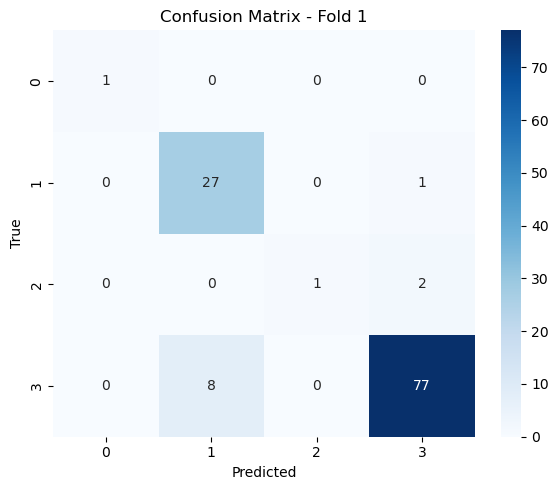


🔹 Đánh giá Fold 2: models/baseline_phoBERT_fold2.pt


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Classification Report (Fold 2 )
              precision    recall  f1-score   support

           0     0.2500    1.0000    0.4000         1
           1     0.7812    0.8929    0.8333        28
           2     0.5000    1.0000    0.6667         3
           3     0.9600    0.8471    0.9000        85

    accuracy                         0.8632       117
   macro avg     0.6228    0.9350    0.7000       117
weighted avg     0.8994    0.8632    0.8738       117



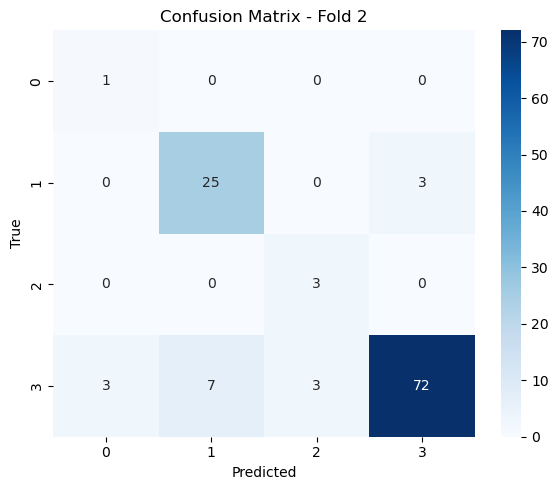


🔹 Đánh giá Fold 3: models/baseline_phoBERT_fold3.pt


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Classification Report (Fold 3 )
              precision    recall  f1-score   support

           0     0.5000    1.0000    0.6667         1
           1     0.8889    0.8571    0.8727        28
           2     0.2000    0.6667    0.3077         3
           3     0.9487    0.8706    0.9080        85

    accuracy                         0.8632       117
   macro avg     0.6344    0.8486    0.6888       117
weighted avg     0.9114    0.8632    0.8821       117



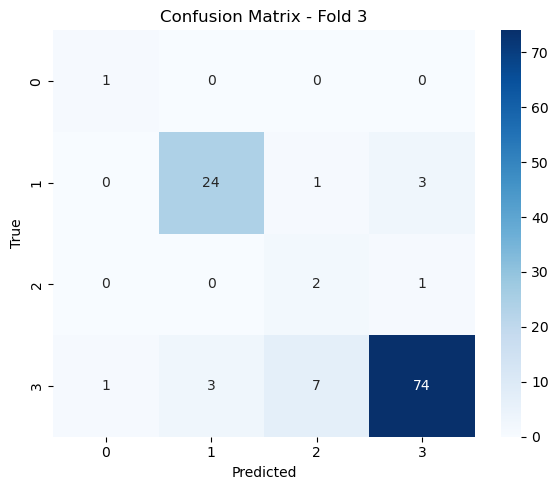


🔹 Đánh giá Fold 4: models/baseline_phoBERT_fold4.pt


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Classification Report (Fold 4 )
              precision    recall  f1-score   support

           0     0.3333    1.0000    0.5000         1
           1     0.8000    0.8571    0.8276        28
           2     0.4286    1.0000    0.6000         3
           3     0.9481    0.8588    0.9012        85

    accuracy                         0.8632       117
   macro avg     0.6275    0.9290    0.7072       117
weighted avg     0.8940    0.8632    0.8725       117



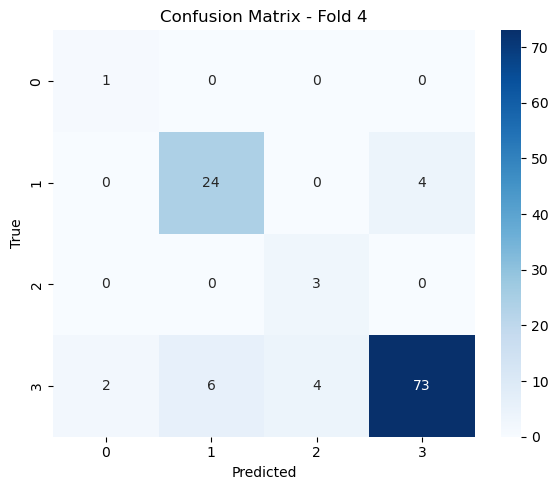


🔹 Đánh giá Fold 5: models/baseline_phoBERT_fold5.pt


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Classification Report (Fold 5 )
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.9091    0.7143    0.8000        28
           2     0.1667    0.3333    0.2222         3
           3     0.8764    0.9176    0.8966        85

    accuracy                         0.8462       117
   macro avg     0.4880    0.4913    0.4797       117
weighted avg     0.8585    0.8462    0.8485       117



c:\Users\Quyen\miniconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Quyen\miniconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Quyen\miniconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c

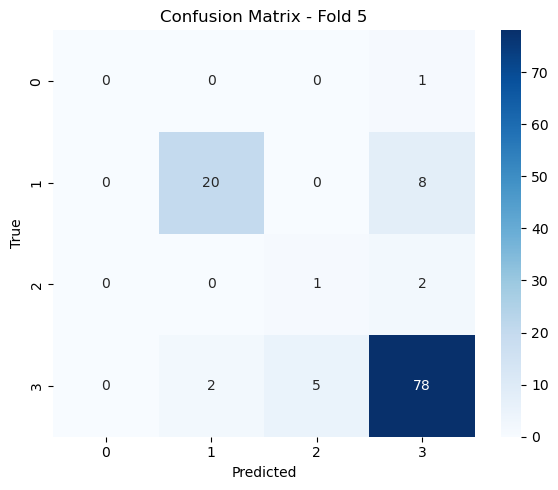


🔹 Đánh giá Fold 6: models/baseline_phoBERT_fold6.pt


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Classification Report (Fold 6 )
              precision    recall  f1-score   support

           0     0.2500    1.0000    0.4000         1
           1     0.7222    0.9286    0.8125        28
           2     0.7500    1.0000    0.8571         3
           3     0.9726    0.8353    0.8987        85

    accuracy                         0.8632       117
   macro avg     0.6737    0.9410    0.7421       117
weighted avg     0.9008    0.8632    0.8728       117



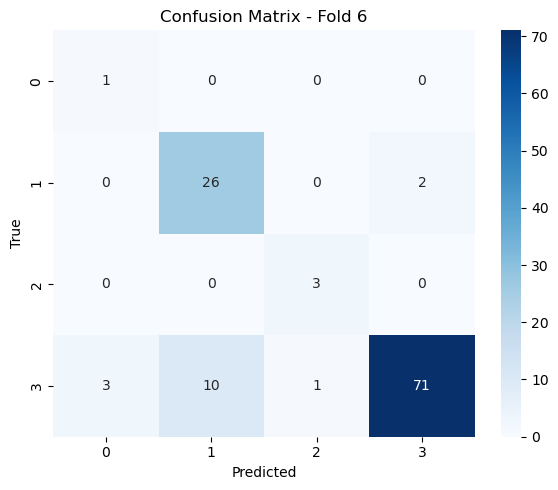


🔹 Đánh giá Fold 7: models/baseline_phoBERT_fold7.pt


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Classification Report (Fold 7 )
              precision    recall  f1-score   support

           0     0.2500    1.0000    0.4000         1
           1     0.7879    0.9286    0.8525        28
           2     1.0000    0.6667    0.8000         3
           3     0.9615    0.8824    0.9202        85

    accuracy                         0.8889       117
   macro avg     0.7499    0.8694    0.7432       117
weighted avg     0.9149    0.8889    0.8965       117



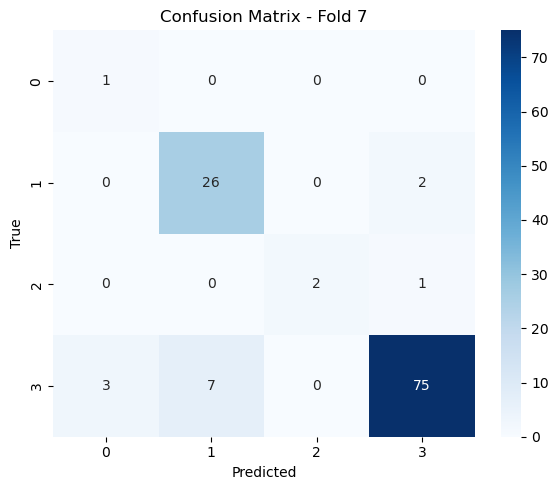


🔹 Đánh giá Fold 8: models/baseline_phoBERT_fold8.pt


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Classification Report (Fold 8 )
              precision    recall  f1-score   support

           0     0.2500    1.0000    0.4000         1
           1     0.8000    0.8571    0.8276        28
           2     0.7500    1.0000    0.8571         3
           3     0.9494    0.8824    0.9146        85

    accuracy                         0.8803       117
   macro avg     0.6873    0.9349    0.7498       117
weighted avg     0.9025    0.8803    0.8879       117



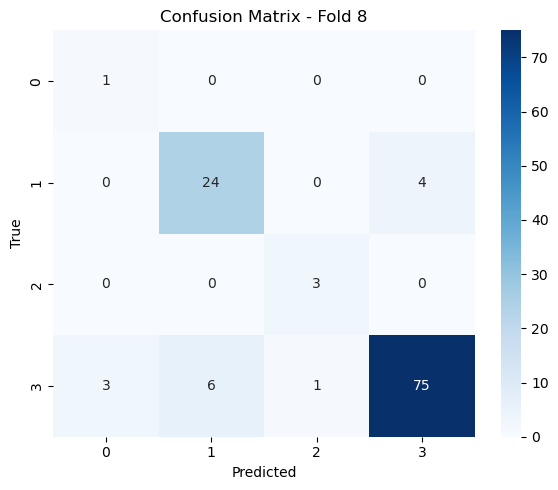


🔹 Đánh giá Fold 9: models/baseline_phoBERT_fold9.pt


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Classification Report (Fold 9 )
              precision    recall  f1-score   support

           0     0.2000    1.0000    0.3333         1
           1     0.7647    0.9286    0.8387        28
           2     0.6667    0.6667    0.6667         3
           3     0.9733    0.8588    0.9125        85

    accuracy                         0.8718       117
   macro avg     0.6512    0.8635    0.6878       117
weighted avg     0.9089    0.8718    0.8836       117



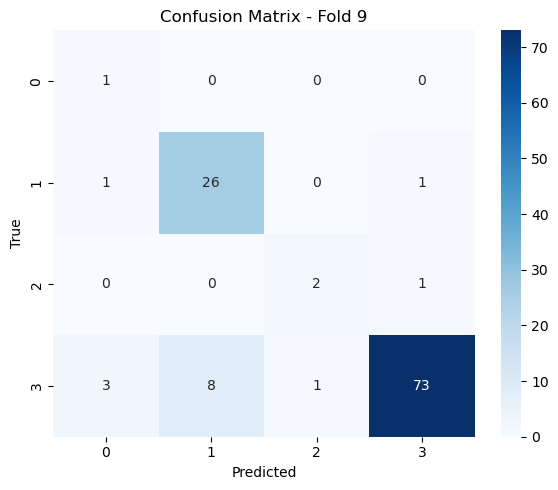


🔹 Đánh giá Fold 10: models/baseline_phoBERT_fold10.pt


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Classification Report (Fold 10 )
              precision    recall  f1-score   support

           0     0.3333    1.0000    0.5000         1
           1     0.8621    0.8929    0.8772        28
           2     1.0000    1.0000    1.0000         3
           3     0.9634    0.9294    0.9461        85

    accuracy                         0.9231       117
   macro avg     0.7897    0.9556    0.8308       117
weighted avg     0.9347    0.9231    0.9272       117



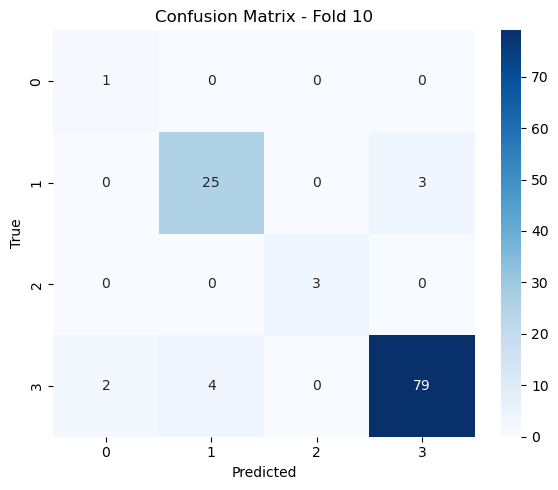


🎯 Mean Test Accuracy: 0.8769 ± 0.0220

📋 Trung bình các chỉ số qua 10 folds:
accuracy    0.876923
dtype: float64


In [13]:
NUM_FOLDS = 10
MODEL_NAME = "vinai/phobert-base"
    
# Khởi tạo tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

# Tạo DataLoader cho tập test
test_dataset = LawDataset(test_df, tokenizer)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
num_labels = len(set(test_df["Subject"]))  # số lớp

# Danh sách lưu kết quả
all_fold_reports = []
all_fold_confusions = []
fold_accs = []

for fold in range(1, NUM_FOLDS + 1):
    model_path = f"models/baseline_phoBERT_fold{fold}.pt"
    print(f"\n{'='*40}")
    print(f"🔹 Đánh giá Fold {fold}: {model_path}")
    print(f"{'='*40}")

    # Khởi tạo model và load trọng số
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels
    )

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Dự đoán trên test set
    preds, labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

    preds = np.array(preds)
    labels = np.array(labels)

    # 🧾 Classification report
    report = classification_report(labels, preds, digits=4, output_dict=True)
    all_fold_reports.append(report)
    fold_accs.append(report["accuracy"])

    # 🔢 Confusion matrix
    cm = confusion_matrix(labels, preds)
    all_fold_confusions.append(cm)

    # Hiển thị
    print("\n📊 Classification Report (Fold", fold, ")")
    print(classification_report(labels, preds, digits=4))

    # Vẽ heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f"{i}" for i in range(num_labels)],
                yticklabels=[f"{i}" for i in range(num_labels)])
    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# 📈 Tổng kết kết quả
print(f"\n🎯 Mean Test Accuracy: {np.mean(fold_accs):.4f} ± {np.std(fold_accs):.4f}")

# Nếu muốn xuất trung bình precision/recall/F1
df_reports = pd.DataFrame(all_fold_reports)
print("\n📋 Trung bình các chỉ số qua 10 folds:")
print(df_reports.mean(numeric_only=True))


## 2.2 CrossEntropyLoss trên bộ dữ liệu cải thiện

### Chia dữ liệu

In [23]:
# Chia dữ liệu train/val/test

df = pd.read_excel("augmented_data.xlsx")

train_df, tmp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["Subject"])    # Cố định random_state để tái lập kết quả, thêm stratify để cân bằng tỉ lệ các lớp
val_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, stratify=tmp_df["Subject"])

le = LabelEncoder()
train_df["Subject"] = le.fit_transform(train_df["Subject"])
val_df["Subject"] = le.transform(val_df["Subject"])
test_df["Subject"]  = le.transform(test_df["Subject"])

# In ra mapping giữa nhãn gốc và số
for idx, class_name in enumerate(le.classes_):
    print(f"Class {idx} -> {class_name}")

Class 0 -> Không có thông tin
Class 1 -> NN
Class 2 -> VN_bé_hơn_14
Class 3 -> VN_lớn_hơn_14


In [24]:
# In ra số lượng mẫu của mỗi lớp trong 3 tập dữ liệu
print("Train class distribution:\n", train_df["Subject"].value_counts())
print("Val class distribution:\n", val_df["Subject"].value_counts())
print("Test class distribution:\n", test_df["Subject"].value_counts())

Train class distribution:
 Subject
3    571
1    312
2    294
0    174
Name: count, dtype: int64
Val class distribution:
 Subject
3    122
1     67
2     62
0     38
Name: count, dtype: int64
Test class distribution:
 Subject
3    123
1     67
2     63
0     37
Name: count, dtype: int64


### Khởi tạo ban đầu

In [25]:

# Khởi tạo tokenizer
MODEL_NAME = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

train_dataset = LawDataset(train_df, tokenizer)
val_dataset   = LawDataset(val_df, tokenizer)
test_dataset  = LawDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

num_labels = len(set(train_df["Subject"]))  # số lớp

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

model.to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Vòng lặp huấn luyện chính

In [ ]:
EPOCHS = 5

# Optimizer và scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

num_training_steps = len(train_loader) * 5  # 5 epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Khởi tạo EarlyStopping
early_stopping = EarlyStopping(patience=2, delta=0.01, path="models/baseline2_phoBERT.pt")

criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, lr_scheduler)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
    print(f"Val loss:   {val_loss:.4f} | Val acc:   {val_acc:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("🛑 Early stopping")
        break


Evaluating: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Epoch 1/5
Train loss: 1.2201 | Train acc: 0.6221
Val loss:   0.8020 | Val acc:   0.8690
✅ Val loss giảm (0.8020 → 0.8020). Lưu model ...


Evaluating: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Epoch 2/5
Train loss: 0.5913 | Train acc: 0.8999
Val loss:   0.3568 | Val acc:   0.9039
✅ Val loss giảm (0.3568 → 0.3568). Lưu model ...


Evaluating: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Epoch 3/5
Train loss: 0.3153 | Train acc: 0.9355
Val loss:   0.2908 | Val acc:   0.8908
✅ Val loss giảm (0.2908 → 0.2908). Lưu model ...


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoch 4/5
Train loss: 0.2184 | Train acc: 0.9560
Val loss:   0.2392 | Val acc:   0.9389
✅ Val loss giảm (0.2392 → 0.2392). Lưu model ...


Evaluating: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]

Epoch 5/5
Train loss: 0.1658 | Train acc: 0.9719
Val loss:   0.2470 | Val acc:   0.9345
⏳ EarlyStopping counter: 1 / 2


### Đánh giá mô hình

Thời gian trung bình mỗi suy luận: 27.43 ms
Tốc độ ~ 36.46 câu/giây
📊 Test Loss: 0.1130
✅ Test Accuracy: 0.9655

Classification Report:
                    precision    recall  f1-score   support

Không có thông tin     1.0000    1.0000    1.0000        37
                NN     0.9552    0.9552    0.9552        67
      VN_bé_hơn_14     0.9538    0.9841    0.9688        63
     VN_lớn_hơn_14     0.9669    0.9512    0.9590       123

          accuracy                         0.9655       290
         macro avg     0.9690    0.9726    0.9707       290
      weighted avg     0.9656    0.9655    0.9655       290



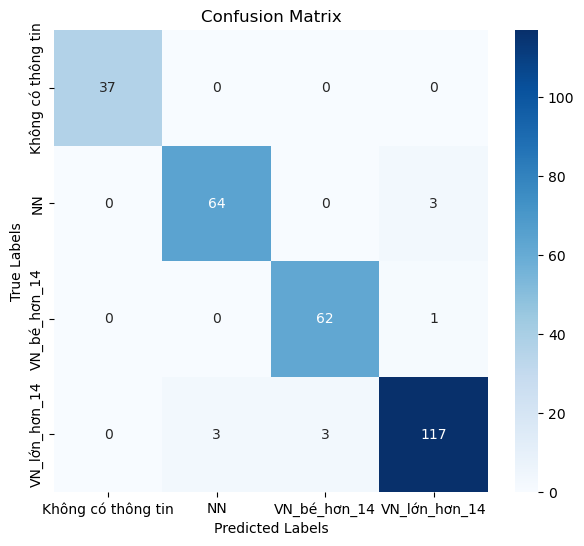

In [32]:
def evaluate_model(model, dataloader, criterion, device, label_names=None):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0

    all_preds = []
    all_labels = []

    start = time.time()

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, targets)

            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            correct = (predictions == targets).sum().item()
            total_correct += correct
            total += targets.size(0)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    end = time.time()
    avg_time = (end - start) / 100

    print(f"Thời gian trung bình mỗi suy luận: {avg_time*1000:.2f} ms")
    print(f"Tốc độ ~ {1/avg_time:.2f} câu/giây")

    avg_loss = total_loss / len(dataloader)
    acc = total_correct / total

    print(f"📊 Test Loss: {avg_loss:.4f}")
    print(f"✅ Test Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_names, digits=4))

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return avg_loss, acc, all_preds, all_labels

# Load model tốt nhất
model.load_state_dict(torch.load("models/baseline2_phoBERT.pt"))
model

# Lấy tên nhãn từ LabelEncoder
label_names = list(le.classes_)

# Đánh giá mô hình trên test set
test_loss, test_acc, test_preds, test_labels = evaluate_model(
    model=model,
    dataloader=test_loader,
    criterion=nn.CrossEntropyLoss(),
    device=device,
    label_names=label_names
)


In [29]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Tổng số tham số: {total_params}")
print(f"Tham số trainable: {trainable_params}")

Tổng số tham số: 135001348
Tham số trainable: 135001348


In [28]:
# Kiểm tra mô hình với câu mới
def predict(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
    return le.inverse_transform(preds)[0]

text = "Việc thay đổi nơi ở của một người có ảnh hưởng như thế nào đến việc đăng ký cư trú của họ, và người này phải làm gì để đảm bảo tuân thủ đúng pháp luật?"
print("Câu hỏi:", text)
print("Dự đoán nhãn:", predict(text, model, tokenizer))

Câu hỏi: Việc thay đổi nơi ở của một người có ảnh hưởng như thế nào đến việc đăng ký cư trú của họ, và người này phải làm gì để đảm bảo tuân thủ đúng pháp luật?
Dự đoán nhãn: VN_lớn_hơn_14


# 3. Mô hình ViLegalBERT

## 3.1 ViLegalBERT fine-tune

### Chia dữ liệu

In [34]:
# Chia dữ liệu train/val/test

df = pd.read_excel("augmented_data.xlsx")

train_df, tmp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["Subject"])    # Cố định random_state để tái lập kết quả, thêm stratify để cân bằng tỉ lệ các lớp
val_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, stratify=tmp_df["Subject"])

le = LabelEncoder()
train_df["Subject"] = le.fit_transform(train_df["Subject"])
val_df["Subject"] = le.transform(val_df["Subject"])
test_df["Subject"]  = le.transform(test_df["Subject"])

# In ra mapping giữa nhãn gốc và số
for idx, class_name in enumerate(le.classes_):
    print(f"Class {idx} -> {class_name}")

Class 0 -> Không có thông tin
Class 1 -> NN
Class 2 -> VN_bé_hơn_14
Class 3 -> VN_lớn_hơn_14


### Khởi tạo ban đầu

In [35]:

# Khởi tạo tokenizer
MODEL_NAME = "htdung167/ViLegalBERT-v0"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = LawDataset(train_df, tokenizer)
val_dataset   = LawDataset(val_df, tokenizer)
test_dataset  = LawDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

num_labels = len(set(train_df["Subject"]))  # số lớp

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

model.to(device)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at htdung167/ViLegalBERT-v0 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

### Hàm train + eval

In [36]:
def train_epoch(model, dataloader, criterion, optimizer, lr_scheduler):
    model.train()
    total_loss, total_preds, total_labels = 0, [], []
    for batch in tqdm(dataloader, desc="Training"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = criterion(outputs.logits, batch["labels"])
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()
        total_preds.extend(preds)
        total_labels.extend(labels)

    acc = accuracy_score(total_labels, total_preds)
    return total_loss / len(dataloader), acc


def eval_epoch(model, dataloader, criterion):
    model.eval()
    total_loss, total_preds, total_labels = 0, [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = criterion(outputs.logits, batch["labels"])
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()
            total_preds.extend(preds)
            total_labels.extend(labels)

    acc = accuracy_score(total_labels, total_preds)
    return total_loss / len(dataloader), acc, total_preds, total_labels


### Vòng lặp huấn luyện chính

In [ ]:
EPOCHS = 4

# Optimizer và scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

num_training_steps = len(train_loader) * 4
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)

# Khởi tạo EarlyStopping
early_stopping = EarlyStopping(patience=2, delta=0.01, path="models/baseline_ViLegalBERT.pt")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, lr_scheduler)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
    print(f"Val loss:   {val_loss:.4f} | Val acc:   {val_acc:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("🛑 Early stopping")
        break


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 1/4
Train loss: 1.0206 | Train acc: 0.5596
Val loss:   0.3761 | Val acc:   0.9066
✅ Val loss giảm (0.3761 → 0.3761). Lưu model ...


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 2/4
Train loss: 0.2280 | Train acc: 0.9423
Val loss:   0.1185 | Val acc:   0.9689
✅ Val loss giảm (0.1185 → 0.1185). Lưu model ...


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 3/4
Train loss: 0.1170 | Train acc: 0.9741
Val loss:   0.0950 | Val acc:   0.9758
✅ Val loss giảm (0.0950 → 0.0950). Lưu model ...


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch 4/4
Train loss: 0.0748 | Train acc: 0.9830
Val loss:   0.0833 | Val acc:   0.9758
✅ Val loss giảm (0.0833 → 0.0833). Lưu model ...


### Đánh giá mô hình

Thời gian trung bình mỗi suy luận: 28.23 ms
Tốc độ ~ 35.42 câu/giây
📊 Test Loss: 0.1062
✅ Test Accuracy: 0.9690

Classification Report:
                    precision    recall  f1-score   support

Không có thông tin     1.0000    1.0000    1.0000        37
                NN     0.9559    0.9701    0.9630        67
      VN_bé_hơn_14     0.9683    0.9683    0.9683        63
     VN_lớn_hơn_14     0.9672    0.9593    0.9633       123

          accuracy                         0.9690       290
         macro avg     0.9728    0.9744    0.9736       290
      weighted avg     0.9690    0.9690    0.9690       290



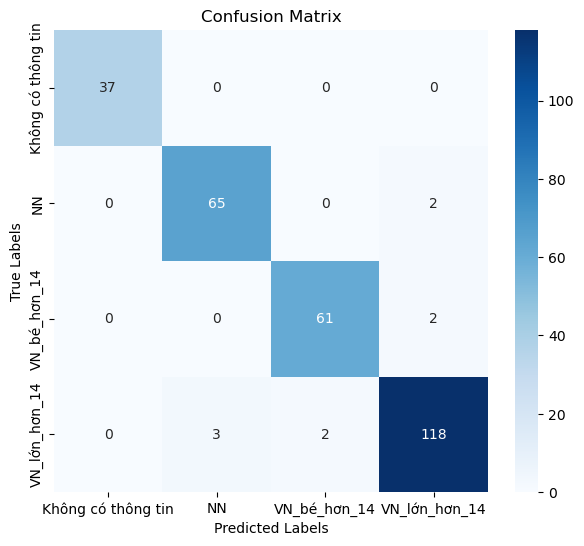

In [37]:
from tracemalloc import start


def evaluate_model(model, dataloader, criterion, device, label_names=None):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0

    all_preds = []
    all_labels = []

    start = time.time()

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, targets)

            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            correct = (predictions == targets).sum().item()
            total_correct += correct
            total += targets.size(0)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    end = time.time()
    avg_time = (end - start) / 100
    print(f"Thời gian trung bình mỗi suy luận: {avg_time*1000:.2f} ms")
    print(f"Tốc độ ~ {1/avg_time:.2f} câu/giây")
    
    avg_loss = total_loss / len(dataloader)
    acc = total_correct / total

    print(f"📊 Test Loss: {avg_loss:.4f}")
    print(f"✅ Test Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_names, digits=4))

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return avg_loss, acc, all_preds, all_labels

# Load model tốt nhất
model.load_state_dict(torch.load("models/baseline_ViLegalBERT.pt"))
model

# Lấy tên nhãn từ LabelEncoder
label_names = list(le.classes_)

# Đánh giá mô hình trên test set
test_loss, test_acc, test_preds, test_labels = evaluate_model(
    model=model,
    dataloader=test_loader,
    device=device,
    criterion=nn.CrossEntropyLoss(),
    label_names=label_names
)


In [39]:
params = sum(p.numel() for p in model.parameters())
print(f"Tổng số tham số: {params}")

Tổng số tham số: 278046724


In [38]:
# Kiểm tra mô hình với câu mới
def predict(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
    return le.inverse_transform(preds)[0]

text = "Việc thay đổi nơi ở của một người có ảnh hưởng như thế nào đến việc đăng ký cư trú của họ, và người này phải làm gì để đảm bảo tuân thủ đúng pháp luật?"
print("Câu hỏi:", text)
print("Dự đoán nhãn:", predict(text, model, tokenizer))

Câu hỏi: Việc thay đổi nơi ở của một người có ảnh hưởng như thế nào đến việc đăng ký cư trú của họ, và người này phải làm gì để đảm bảo tuân thủ đúng pháp luật?
Dự đoán nhãn: VN_lớn_hơn_14


## 3.2 ViLegalBERT + CNN + Attention

### ViLegalBERT + CNN + Attention

In [40]:
class ViLegalCNN_Attn(nn.Module):
    def __init__(self, model_name, num_labels, dropout=0.25):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        hidden_size = self.bert.config.hidden_size  # 768

        # CNN head (giảm số filter để tránh overfitting)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=hidden_size, out_channels=64, kernel_size=k)
            for k in [2, 3, 4]
        ])

        # Attention head
        self.attn = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=4, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(64 * 3 + hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state  # [B, L, H]

        # CNN path
        x_cnn = last_hidden.transpose(1, 2)  # [B, H, L]
        conv_outs = []

        for conv in self.convs:
            conv_x = torch.relu(conv(x_cnn))       # [B, 64, L - k + 1]
            pooled = torch.amax(conv_x, dim=2)     # [B, 64]
            conv_outs.append(pooled)

        cnn_feat = torch.cat(conv_outs, dim=1)     # [B, 64*3]


        # Attention path
        attn_out, _ = self.attn(last_hidden, last_hidden, last_hidden)
        attn_feat = attn_out.mean(dim=1)  # [B, H]

        # Combine features
        feat = torch.cat([cnn_feat, attn_feat], dim=1)
        out = self.fc(self.dropout(feat))
        return out


### Chuẩn bị dữ liệu + class-weight

In [41]:
MODEL_NAME = "htdung167/ViLegalBERT-v0"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

df = pd.read_excel("augmented_data.xlsx")

train_df, tmp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["Subject"])
val_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, stratify=tmp_df["Subject"])

le = LabelEncoder()
train_df["Subject"] = le.fit_transform(train_df["Subject"])
val_df["Subject"] = le.fit_transform(val_df["Subject"])
test_df["Subject"]  = le.transform(test_df["Subject"])

train_dataset = LawDataset(train_df, tokenizer)
val_dataset = LawDataset(val_df, tokenizer)
test_dataset = LawDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

num_labels = len(set(train_df["Subject"]))  # số lớp

# Tính class-weight
labels_np = np.array(train_df["Subject"])
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels_np),
                                     y=labels_np)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([1.9411, 1.0825, 1.1488, 0.5915], device='cuda:0')


### Khai báo mô hình

In [42]:
model = ViLegalCNN_Attn(MODEL_NAME, num_labels).to(device)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at htdung167/ViLegalBERT-v0 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
for name, param in model.named_parameters():
    if 'cnn' in name or 'attn' in name:
        param.requires_grad = True

In [44]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

### Hàm train / eval

In [45]:
def train_epoch(model, loader, criterion, optimizer, scheduler):
    model.train()
    total_loss, total_preds = 0, []

    for batch in tqdm(loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()

        for name, param in model.named_parameters():
            if 'cnn' in name:
                print(name, param.grad is not None)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
    return total_loss / len(loader)


def eval_epoch(model, loader, criterion):
    model.eval()
    preds, labels_all = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds += torch.argmax(outputs, dim=1).cpu().tolist()
            labels_all += labels.cpu().tolist()

    f1 = f1_score(labels_all, preds, average='macro')
    return total_loss / len(loader), f1, preds, labels_all


### Huấn luyện chính

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_epochs = 4
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=int(0.1 * total_steps),
                                            num_training_steps=total_steps)

early_stopping = EarlyStopping(patience=2, delta=0.01, path="models/baseline_vilegalbert_cnn_attn.pt")

best_f1 = 0
for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")
    train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler)
    val_loss, val_f1, _, _ = eval_epoch(model, val_loader, criterion)

    print(f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("🛑 Early stopping")
        break



===== Epoch 1/4 =====


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Train loss: 1.0493 | Val loss: 0.3988 | Val F1: 0.9087
✅ Val loss giảm (0.3988 → 0.3988). Lưu model ...

===== Epoch 2/4 =====


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Train loss: 0.2085 | Val loss: 0.1204 | Val F1: 0.9623
✅ Val loss giảm (0.1204 → 0.1204). Lưu model ...

===== Epoch 3/4 =====


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Train loss: 0.1033 | Val loss: 0.0696 | Val F1: 0.9783
✅ Val loss giảm (0.0696 → 0.0696). Lưu model ...

===== Epoch 4/4 =====


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

Train loss: 0.0638 | Val loss: 0.0757 | Val F1: 0.9783
⏳ EarlyStopping counter: 1 / 2


### Đánh giá mô hình

In [46]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

Some weights of XLMRobertaModel were not initialized from the model checkpoint at htdung167/ViLegalBERT-v0 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Thời gian trung bình mỗi suy luận: 30.38 ms
Tốc độ ~ 32.92 câu/giây

✅ Test Loss: 0.1329

===== 📋 Classification Report =====
                    precision    recall  f1-score   support

     VN_lớn_hơn_14     1.0000    1.0000    1.0000        37
                NN     0.9559    0.9701    0.9630        67
      VN_bé_hơn_14     0.9839    0.9683    0.9760        63
Không có thông tin     0.9675    0.9675    0.9675       123

          accuracy                         0.9724       290
         macro avg     0.9768    0.9765    0.9766       290
      weighted avg     0.9725    0.9724    0.9724       290



C:\Users\Quyen\AppData\Local\Temp\ipykernel_19524\4137702053.py:56: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Quyen\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


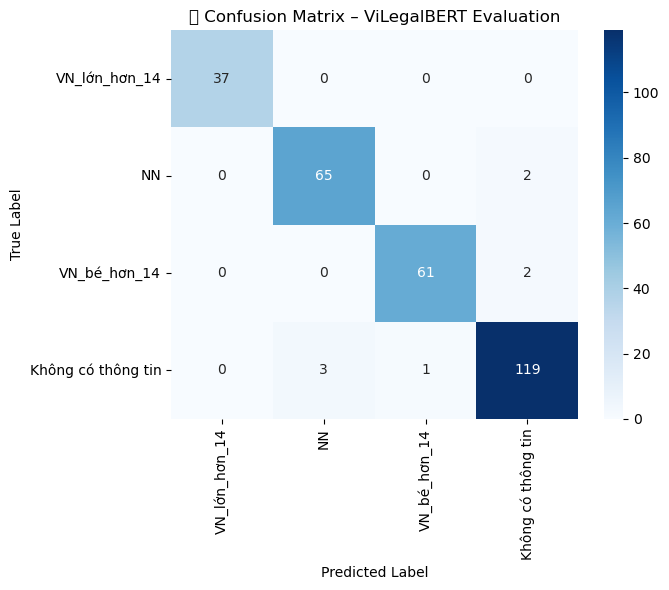

In [47]:
model = ViLegalCNN_Attn(MODEL_NAME, num_labels).to(device)

model.load_state_dict(torch.load("models/baseline_vilegalbert_cnn_attn.pt"))
model.to(device)
model.eval()

def eval_model(model, dataloader, device):
    preds, labels = [], []
    total_loss, total_correct = 0, 0
    criterion = torch.nn.CrossEntropyLoss()

    start = time.time()

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            label = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs
            loss = criterion(logits, label)

            total_loss += loss.item()
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels.extend(label.cpu().numpy())

    end = time.time()
    avg_time = (end - start) / 100
    print(f"Thời gian trung bình mỗi suy luận: {avg_time*1000:.2f} ms")
    print(f"Tốc độ ~ {1/avg_time:.2f} câu/giây")

    avg_loss = total_loss / len(dataloader)
    return avg_loss, np.array(preds), np.array(labels)

test_loss, test_preds, test_labels = eval_model(model, test_loader, device)

print(f"\n✅ Test Loss: {test_loss:.4f}")

target_names = ["VN_lớn_hơn_14", "NN", "VN_bé_hơn_14", "Không có thông tin"]

print("\n===== 📋 Classification Report =====")
print(classification_report(
    test_labels, 
    test_preds, 
    target_names=target_names, 
    digits=4
))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("🔍 Confusion Matrix – ViLegalBERT Evaluation")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [49]:
params = sum(p.numel() for p in model.parameters())
print(f"Tổng số tham số: {params}")

Tổng số tham số: 280852420


In [48]:
# Kiểm tra mô hình với câu mới
def predict(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
    return le.inverse_transform(preds)[0]

text = "Việc thay đổi nơi ở của một người có ảnh hưởng như thế nào đến việc đăng ký cư trú của họ, và người này phải làm gì để đảm bảo tuân thủ đúng pháp luật?"
print("Câu hỏi:", text)
print("Dự đoán nhãn:", predict(text, model, tokenizer))

Câu hỏi: Việc thay đổi nơi ở của một người có ảnh hưởng như thế nào đến việc đăng ký cư trú của họ, và người này phải làm gì để đảm bảo tuân thủ đúng pháp luật?
Dự đoán nhãn: VN_lớn_hơn_14
